In [13]:
from notebook_helpers import *

In [14]:
import dask.array as da
from scipy.interpolate import RBFInterpolator

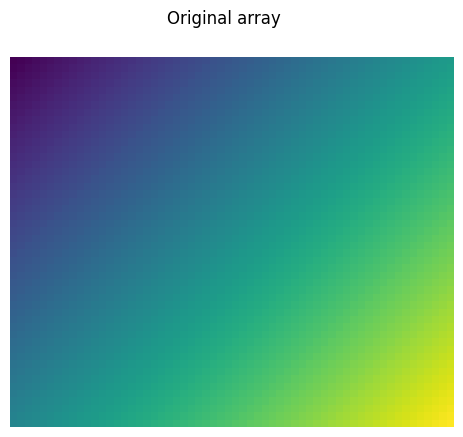

In [15]:
shape = (50, 40, 60)
# shape = (528, 320, 456)

original_array = np.array(
    [
        i + j + k
        for i in range(shape[0])
        for j in range(shape[1])
        for k in range(shape[2])
    ]
).reshape(shape)

imshow(original_array[:, 0], title="Original array")

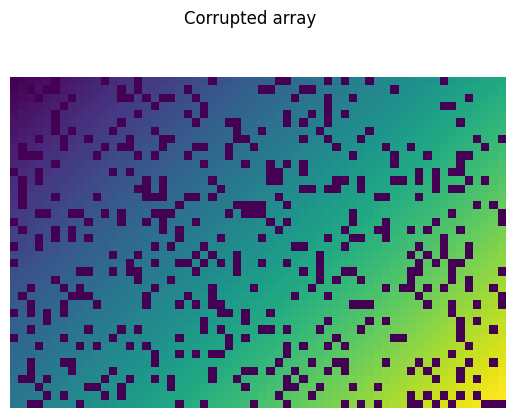

In [16]:
corruption_rate = 0.2
corrupted_array = original_array.copy()
corrupted_array[
    np.where(
        np.random.choice(
            [0, 1], size=np.prod(shape), p=[1 - corruption_rate, corruption_rate]
        ).reshape(shape)
        > 0
    )
] = 0

imshow(corrupted_array[0], title="Corrupted array")

In [17]:
known_coordinates = np.where(corrupted_array > 0)
known_points = np.array(known_coordinates).T

known_values = corrupted_array[known_coordinates]

x_grid_coordinates, y_grid_coordinates, z_grid_coordinates = np.meshgrid(
    range(corrupted_array.shape[0]),
    range(corrupted_array.shape[1]),
    range(corrupted_array.shape[2]),
)

In [18]:
interpolator = RBFInterpolator(
    known_points,
    known_values,
    kernel="thin_plate_spline",
    neighbors=4**3,
)

In [19]:
target_coordinates = np.array(
    [
        x_grid_coordinates.flatten(),
        y_grid_coordinates.flatten(),
        z_grid_coordinates.flatten(),
    ]
)
target_points = np.array(target_coordinates).T

recovered_data = interpolator(target_points)

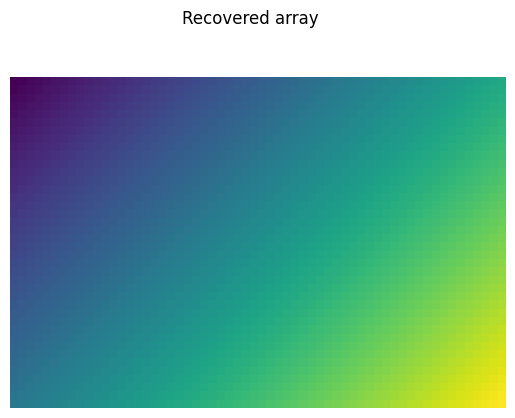

In [20]:
recovered_array = recovered_data.reshape(shape)

imshow(recovered_array[0], title="Recovered array")

RMSE: 17.84656829757475


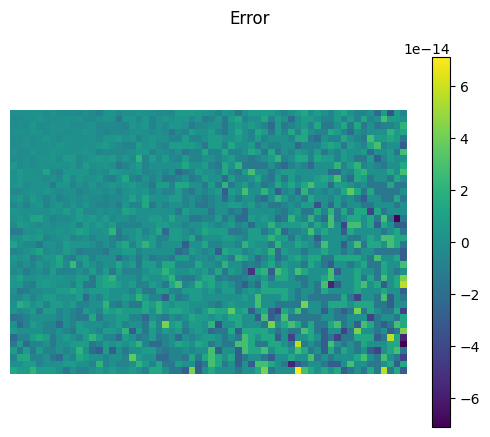

In [21]:
error_array = original_array - recovered_array

rmse = np.sqrt(np.mean(error_array**2))

print(f"RMSE: {rmse}")

imshow(error_array[0], colorbar=True, title="Error")

# Comparisons

In [22]:
# target_coordinates = np.array(
#     [
#         x_grid_coordinates.flatten(),
#         y_grid_coordinates.flatten(),
#         z_grid_coordinates.flatten(),
#     ]
# )
# target_points = np.array(target_coordinates).T
#
#
# recovered_data = interpolator(target_points)
#
# for kernel in ["linear", "thin_plate_spline", "cubic", "quintic", "multiquadric", "inverse_multiquadric", "inverse_quadratic", "gaussian"]:
#     if kernel in ["multiquadric", "inverse_multiquadric", "inverse_quadratic", "gaussian"]:
#         epsilon = 0.1
#     else:
#         epsilon = 1
#
#     interpolator = RBFInterpolator(
#         known_points,
#         known_values,
#         kernel=kernel,
#         neighbors=4**3,
#         epsilon=1,
#     )
#
#     recovered_data = interpolator(target_points)
#
#     recovered_array = recovered_data.reshape(shape)
#
#     imshow(recovered_array[0], title="Recovered array")
#
#     error_array = original_array - recovered_array
#
#     rmse = np.sqrt(np.mean(error_array ** 2))
#
#     print(f"RMSE for {kernel}: {rmse}")
#
#     imshow(error_array[0], colorbar=True, title="Error")

# Chunking

In [23]:
da_target_points = da.from_array(target_points, chunks=(None, 3))

da_recovered_data = da.map_blocks(
    interpolator, da_target_points, drop_axis=1, dtype=np.float64, enforce_ndim=True
).compute()

In [24]:
da_recovered_data.shape == recovered_data.shape

True